In [1]:
!pip install /kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl

Processing /kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl


In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoModel

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/smiles-extra-data/data_dnst1.xlsx
/kaggle/input/smiles-extra-data/data_tg3.xlsx
/kaggle/input/smiles-extra-data/JCIM_sup_bigsmiles.csv
/kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl
/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM/config.json
/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM/merges.txt
/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM/tokenizer.json
/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM/vocab.json
/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM/tokenizer_config.json
/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM/model.safetensors
/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM/special_tokens_map.json
/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM/added_tokens.json
/kaggle/input/polybert/polyBERT-local/spm.model
/kaggle/input/polybert/polyBERT-local/config.json
/kaggle/input/polybert/polyBERT-local/README.md
/kaggle/input/polybert/polyBER

In [9]:
import torch
from transformers import AutoTokenizer, AutoModel

MODEL_DIR = "/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM"
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_ENCODER = True

class HFEncoder:
    def __init__(self, model_dir, device, pooling="mean"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
        self.model     = AutoModel.from_pretrained(model_dir).to(device).eval()
        self.device    = device
        self.pooling   = pooling

    @torch.no_grad()
    def encode(self, smiles_list, device=None, convert_to_tensor=True,
               show_progress_bar=False, batch_size=256):
        device = device or self.device
        out_chunks = []
        for i in range(0, len(smiles_list), batch_size):
            batch = smiles_list[i:i+batch_size]
            tok = self.tokenizer(batch, padding=True, truncation=True,
                                 return_tensors="pt").to(device)
            hidden = self.model(**tok).last_hidden_state  # [B, L, H]
            if self.pooling == "cls":
                emb = hidden[:, 0]                         # CLS token
            else:  # mean pooling (mask-aware)
                mask = tok["attention_mask"].unsqueeze(-1)
                emb  = (hidden * mask).sum(1) / mask.sum(1)
            out_chunks.append(emb.cpu())
        embs = torch.cat(out_chunks, 0)
        return embs if convert_to_tensor else embs.numpy()

ENCODER = HFEncoder(MODEL_DIR, DEVICE, pooling="mean")

EMB_DIM = ENCODER.model.config.hidden_size # 600


In [10]:
EMB_DIM

384

In [11]:
ROOT = '/kaggle/input/neurips-open-polymer-prediction-2025/'
df_train = pd.read_csv(os.path.join(ROOT, "train.csv"))
df_train.isnull().sum()

id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

In [12]:
import os
import pandas as pd

# -------------------------------------------------
# 0.  Paths & core targets
# -------------------------------------------------
ROOT       = '/kaggle/input/neurips-open-polymer-prediction-2025/'
SUPP_ROOT  = os.path.join(ROOT, 'train_supplement')
EXTRA_TC   = '/kaggle/input/tc-smiles/Tc_SMILES.csv'
EXTRA_TG_XLSX = '/kaggle/input/smiles-extra-data/data_tg3.xlsx'
EXTRA_TG_BIG  = '/kaggle/input/smiles-extra-data/JCIM_sup_bigsmiles.csv'

targets = ["Tg", "FFV", "Tc", "Density", "Rg"]

# -------------------------------------------------
# 1.  Start with main train.csv
# -------------------------------------------------
df_main = pd.read_csv(os.path.join(ROOT, "train.csv"))

property_datasets = {
    t: df_main[["SMILES", t]].dropna().reset_index(drop=True).copy()
    for t in targets
}

# -------------------------------------------------
# 2.  Supplement from /train_supplement
#     (indent fix – Tc-specific logic remains inside loop)
# -------------------------------------------------
for fname in os.listdir(SUPP_ROOT):
    if not fname.endswith(".csv"):
        continue

    supp_df = pd.read_csv(os.path.join(SUPP_ROOT, fname))

    for t in targets:
        # direct column match
        if t in supp_df.columns:
            subset = supp_df[["SMILES", t]].dropna()
            print(f"[supp] {len(subset):4d} → {t}  ({fname})")
            property_datasets[t] = pd.concat(
                [property_datasets[t], subset], ignore_index=True
            )

        # special case: TC_mean → Tc
        if t == "Tc" and "TC_mean" in supp_df.columns:
            subset = (
                supp_df[["SMILES", "TC_mean"]]
                .dropna()
                .rename(columns={"TC_mean": "Tc"})
            )
            print(f"[supp] {len(subset):4d} → Tc (TC_mean in {fname})")
            property_datasets["Tc"] = pd.concat(
                [property_datasets["Tc"], subset], ignore_index=True
            )

# -------------------------------------------------
# 3.  Extra file 1:  Tc_SMILES.csv
# -------------------------------------------------
if os.path.exists(EXTRA_TC):
    df_tc = pd.read_csv(EXTRA_TC)

    # Normalise column names just in case
    df_tc.columns = df_tc.columns.str.strip()
    if {"SMILES", "TC_mean"}.issubset(df_tc.columns):
        subset = df_tc[["SMILES", "TC_mean"]].dropna().rename(
            columns={"TC_mean": "Tc"}
        )
        print(f"[extra] {len(subset):4d} → Tc  (Tc_SMILES.csv)")
        property_datasets["Tc"] = pd.concat(
            [property_datasets["Tc"], subset], ignore_index=True
        )

# -------------------------------------------------
# 4.  Extra file 2:  data_tg3.xlsx  (Kelvin → Celsius)
# -------------------------------------------------
if os.path.exists(EXTRA_TG_XLSX):
    df_tg_k = pd.read_excel(EXTRA_TG_XLSX, sheet_name="Лист1")

    df_tg_k.columns = df_tg_k.columns.str.strip()
    if {"SMILES", "Tg [K]"}.issubset(df_tg_k.columns):
        subset = (
            df_tg_k[["SMILES", "Tg [K]"]]
            .dropna()
            .rename(columns={"Tg [K]": "Tg"})
        )
        subset["Tg"] = subset["Tg"] - 273.15  # K ➜ °C
        print(f"[extra] {len(subset):4d} → Tg  (converted K→C, data_tg3.xlsx)")
        property_datasets["Tg"] = pd.concat(
            [property_datasets["Tg"], subset], ignore_index=True
        )

# -------------------------------------------------
# 5.  Extra file 3:  JCIM_sup_bigsmiles.csv  (already °C)
# -------------------------------------------------
if os.path.exists(EXTRA_TG_BIG):
    df_big = pd.read_csv(EXTRA_TG_BIG)

    df_big.columns = df_big.columns.str.strip()
    if {"SMILES", "Tg (C)"}.issubset(df_big.columns):
        subset = df_big[["SMILES", "Tg (C)"]].dropna().rename(
            columns={"Tg (C)": "Tg"}
        )
        print(f"[extra] {len(subset):4d} → Tg  (JCIM_sup_bigsmiles.csv)")
        property_datasets["Tg"] = pd.concat(
            [property_datasets["Tg"], subset], ignore_index=True
        )

# -------------------------------------------------
# 5.1  Extra file 4: data_dnst1.xlsx  (Density in g/cm³)
# -------------------------------------------------

EXTRA_DENS_XLSX = "/kaggle/input/smiles-extra-data/data_dnst1.xlsx"

if os.path.exists(EXTRA_DENS_XLSX):
    df_dn = pd.read_excel(EXTRA_DENS_XLSX, sheet_name="MatrixRaw")
    df_dn.columns = df_dn.columns.str.strip()

    smiles_col = "SMILES" if "SMILES" in df_dn.columns else "uSMILES"
    if {smiles_col, "density(g/cm3)"}.issubset(df_dn.columns):
        subset = (
            df_dn[[smiles_col, "density(g/cm3)"]]
            .rename(columns={smiles_col: "SMILES", "density(g/cm3)": "Density"})
        )

        # exactly what you said:
        subset["Density"] = pd.to_numeric(subset["Density"], errors="coerce").astype("float64")
        subset["Density"] = subset["Density"] - 0.118

        subset = subset.dropna(subset=["Density"])
        subset["source"] = "dnst1"   # optional: keep track

        print(f"[extra] {len(subset):4d} → Density  (data_dnst1.xlsx / MatrixRaw, −0.118 applied)")
        property_datasets["Density"] = pd.concat(
            [property_datasets["Density"], subset], ignore_index=True
        )
    else:
        print("[warn] Missing required columns in data_dnst1.xlsx")

# -------------------------------------------------
# 6.  Final tidy‑up: drop duplicates per‑target
# -------------------------------------------------
from rdkit import Chem

def canonicalize_smiles(s: str) -> str | None:
    if not isinstance(s, str) or not s:
        return None
    m = Chem.MolFromSmiles(s, sanitize=True)
    if m is None:
        return s
    # canonical=True by default; keep stereochemistry
    return Chem.MolToSmiles(m, canonical=True, isomericSmiles=True)


for t in targets:
    df = property_datasets[t].copy()

    # apply canon; drop failures
    df["SMILES_canon"] = df["SMILES"].map(canonicalize_smiles)
    n_fail = df["SMILES_canon"].isna().sum()
    if n_fail:
        print(f"[canon] {t}: dropped {n_fail} rows with invalid SMILES")

    df = df.dropna(subset=["SMILES_canon"])

    # re-dedup on canonical SMILES (keep first target value)
    before = len(df)
    df = df.drop_duplicates(subset=["SMILES_canon"]).reset_index(drop=True)
    after = len(df)
    print(f"[canon] {t}: {after} unique after canonicalization (removed {before - after})")

    # replace original SMILES with canonical (and optionally keep the original)
    df["SMILES_orig"] = df["SMILES"]  # optional: keep provenance
    df["SMILES"] = df["SMILES_canon"]
    df = df.drop(columns=["SMILES_canon"])

    property_datasets[t] = df


[supp]  862 → FFV  (dataset4.csv)
[supp]  874 → Tc (TC_mean in dataset1.csv)
[supp]   46 → Tg  (dataset3.csv)
[extra]  874 → Tc  (Tc_SMILES.csv)
[extra]  501 → Tg  (converted K→C, data_tg3.xlsx)
[extra]  662 → Tg  (JCIM_sup_bigsmiles.csv)
[extra]  786 → Density  (data_dnst1.xlsx / MatrixRaw, −0.118 applied)
[canon] Tg: 1161 unique after canonicalization (removed 559)
[canon] FFV: 7892 unique after canonicalization (removed 0)
[canon] Tc: 866 unique after canonicalization (removed 1619)
[canon] Density: 1253 unique after canonicalization (removed 146)
[canon] Rg: 614 unique after canonicalization (removed 0)


[23:05:11] SMILES Parse Error: syntax error while parsing: *O[Si](*)([R])[R]
[23:05:11] SMILES Parse Error: check for mistakes around position 12:
[23:05:11] *O[Si](*)([R])[R]
[23:05:11] ~~~~~~~~~~~^
[23:05:11] SMILES Parse Error: Failed parsing SMILES '*O[Si](*)([R])[R]' for input: '*O[Si](*)([R])[R]'
[23:05:11] SMILES Parse Error: syntax error while parsing: *NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4
[23:05:11] SMILES Parse Error: check for mistakes around position 28:
[23:05:11] c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=
[23:05:11] ~~~~~~~~~~~~~~~~~~~~^
[23:05:11] SMILES Parse Error: Failed parsing SMILES '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4' for input: '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4'
[23:05:11] SMILES Parse Error: syntax error while parsing: O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[23:05:11] SMILES Parse Error: check for mistakes around position 7:
[23:05:11] O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[23:05:11] ~~~~~~^
[23:05:11] SMILES Parse Error: F


=== Tg ===
           count     min     max  median    mean      std
original   511.0 -148.03  472.25  74.040  96.452  111.228
added      654.0 -255.15  442.63  29.850  20.000  121.665
combined  1161.0 -255.15  472.25  47.383  53.349  123.209


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l


=== FFV ===
           count    min    max  median   mean    std
original  7030.0  0.227  0.777   0.364  0.367  0.030
added      875.0  0.281  0.525   0.362  0.366  0.024
combined  7892.0  0.227  0.777   0.364  0.367  0.029


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l


=== Tc ===
          count    min    max  median   mean    std
original  737.0  0.046  0.524   0.236  0.256  0.090
added     129.0  0.091  1.590   0.235  0.258  0.152
combined  866.0  0.046  1.590   0.236  0.257  0.101


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l


=== Density ===
           count    min    max  median   mean    std
original   613.0  0.749  1.841   0.948  0.985  0.146
added      640.0  0.752  1.982   1.132  1.155  0.228
combined  1253.0  0.749  1.982   1.032  1.072  0.210


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l


=== Rg ===
          count    min     max  median   mean    std
original  614.0  9.728  34.673  15.052  16.42  4.609
added       0.0    NaN     NaN     NaN    NaN    NaN
combined  614.0  9.728  34.673  15.052  16.42  4.609


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6)

count      min      max  median    mean      std
Tg      original   511.0 -148.030  472.250  74.040  96.452  111.228
        added      654.0 -255.150  442.630  29.850  20.000  121.665
        combined  1161.0 -255.150  472.250  47.383  53.349  123.209
FFV     original  7030.0    0.227    0.777   0.364   0.367    0.030
        added      875.0    0.281    0.525   0.362   0.366    0.024
        combined  7892.0    0.227    0.777   0.364   0.367    0.029
Tc      original   737.0    0.046    0.524   0.236   0.256    0.090
        added      129.0    0.091    1.590   0.235   0.258    0.152
        combined   866.0    0.046    1.590   0.236   0.257    0.101
Density original   613.0    0.749    1.841   0.948   0.985    0.146
        added      640.0    0.752    1.982   1.132   1.155    0.228
        combined  1253.0    0.749    1.982   1.032   1.072    0.210
Rg      original   614.0    9.728   34.673  15.052  16.420    4.609
        added        0.0      NaN      NaN     NaN     NaN      NaN
        combined   614.0    9.728   34.673  15.052  16.420    4.609

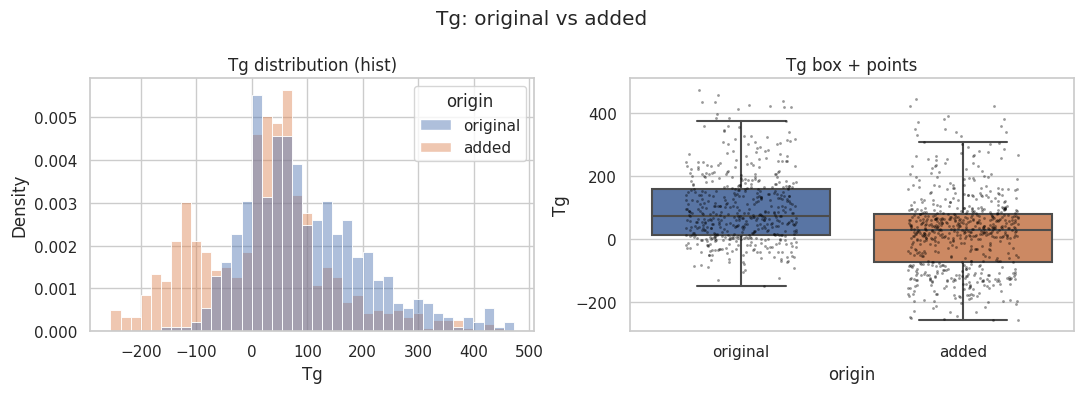

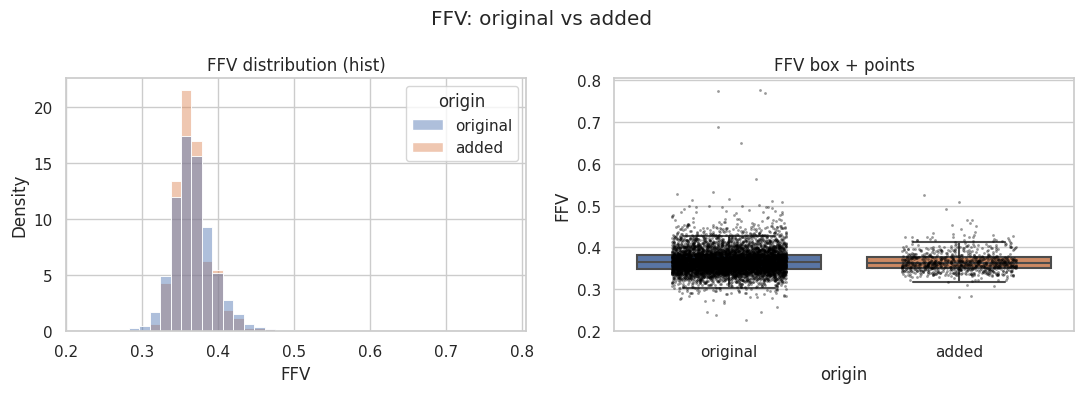

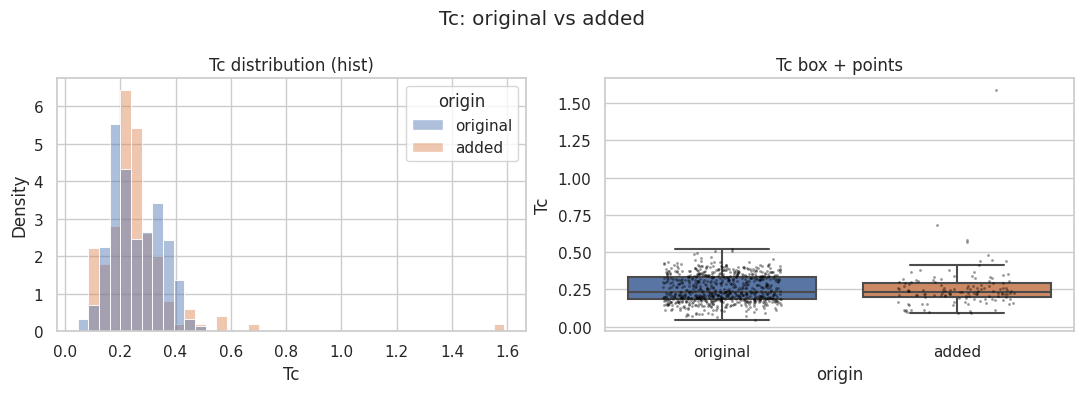

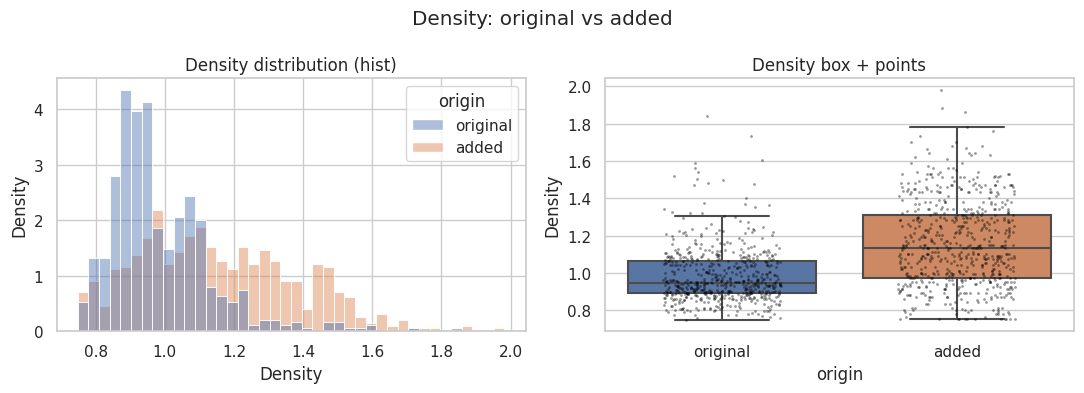

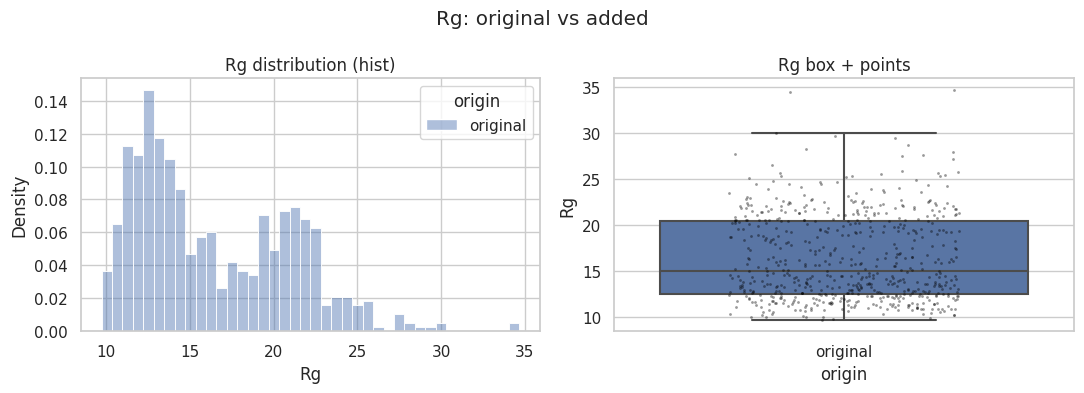

In [13]:
# -------------------------------------------------
# 7.  Compare original vs added data (stats + plots)
# -------------------------------------------------
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

def summarize_and_plot(t, df_main, df_all):
    """
    df_main: original train.csv subset -> columns: SMILES, t
    df_all : property_datasets[t] after merges -> columns: SMILES, t
    """
    orig = df_main[["SMILES", t]].dropna().drop_duplicates("SMILES")
    all_  = df_all[["SMILES", t]].dropna().drop_duplicates("SMILES")

    # mark which rows are NEW (not in original)
    merged = all_.merge(orig[["SMILES"]], on="SMILES", how="left", indicator=True)
    merged["origin"] = np.where(merged["_merge"] == "both", "original", "added")
    merged = merged.drop(columns=["_merge"])

    # ---- stats
    def agg_stats(s):
        return pd.Series({
            "count":  int(s.count()),
            "min":    float(s.min()),
            "max":    float(s.max()),
            "median": float(s.median()),
            "mean":   float(s.mean()),
            "std":    float(s.std(ddof=1))
        })

    stats = {
        "original": agg_stats(orig[t]),
        "added":    agg_stats(merged.loc[merged["origin"] == "added", t]),
        "combined": agg_stats(all_[t])
    }
    stats_df = pd.DataFrame(stats).T.round(3)

    print(f"\n=== {t} ===")
    print(stats_df)

    # ---- plots
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    # histogram / kde
    sns.histplot(data=merged, x=t, hue="origin",
                 bins=40, stat="density", common_norm=False,
                 alpha=0.45, edgecolor=None, ax=axes[0])
    axes[0].set_title(f"{t} distribution (hist)")
    # box/violin
    sns.boxplot(data=merged, x="origin", y=t, ax=axes[1], showfliers=False)
    sns.stripplot(data=merged, x="origin", y=t, ax=axes[1],
                  size=2, jitter=0.25, alpha=0.4, color="black")
    axes[1].set_title(f"{t} box + points")

    plt.suptitle(f"{t}: original vs added")
    plt.tight_layout()
    return stats_df

all_stats = {}
for t in targets:
    all_stats[t] = summarize_and_plot(
        t,
        df_main[["SMILES", t]],
        property_datasets[t]
    )

# Optional: collect all stats in one table
summary_table = pd.concat(all_stats, axis=0)
display(summary_table)


In [14]:
import os, json, hashlib, pickle, torch, numpy as np
from tqdm import tqdm

BATCH = 1024

# 1) Collect all SMILES once
all_smiles = sorted({s for df in property_datasets.values() for s in df["SMILES"].unique()})

# 2) Build a fingerprint of anything that should force re-cache
def make_fingerprint(encoder, smiles, extra=None):
    h = hashlib.sha256()
    h.update(json.dumps(smiles).encode())          # data changes
    h.update(str(type(encoder)).encode())          # encoder class
    h.update(str(getattr(encoder, "config", "")).encode())  # encoder config if present
    if extra: h.update(json.dumps(extra, sort_keys=True).encode())
    return h.hexdigest()[:12]

FPRINT = make_fingerprint(ENCODER, all_smiles, extra={"batch": BATCH})
CACHE_FILE = f"smiles_emb_{FPRINT}.pkl"

# 3) Load cache if it matches, else start fresh
if TRAIN_ENCODER:
    smiles2emb = None   # don't build it
else:
    if os.path.exists(CACHE_FILE):
        cache = pickle.load(open(CACHE_FILE, "rb"))
        smiles2emb = cache["emb"]
    else:
        smiles2emb = {}
    
    # 4) Encode only SMILES not in the cache
    missing = [s for s in all_smiles if s not in smiles2emb]
    if missing:
        for i in tqdm(range(0, len(missing), BATCH)):
            batch = missing[i:i+BATCH]
            with torch.no_grad():
                emb = ENCODER.encode(batch, device=DEVICE, convert_to_tensor=True,
                                     show_progress_bar=False).cpu().numpy().astype(np.float32)
            smiles2emb.update(dict(zip(batch, emb)))
    
        pickle.dump({"emb": smiles2emb, "fingerprint": FPRINT}, open(CACHE_FILE, "wb"))
        print(f"✅  Saved/updated cache → {CACHE_FILE}")
    else:
        print("⏩  Cache is up to date.")


In [15]:
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors, rdmolops
import networkx as nx
import numpy as np
from tqdm import tqdm

import re
POLY_TOKEN_RE = re.compile(r"\*|\[R\d*'?]")   # *  [R], [R1], [R']
def clean_poly_smiles(s):
    return POLY_TOKEN_RE.sub("C", s)   # crude: replace with carbon


# --- 1.  RDKit descriptor setup -------------------------------------------
descriptor_names = [d[0] for d in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

BAD_COLS = {11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25}  # 0‑based

# --- 2.  helpers -----------------------------------------------------------
zero_desc = [0.0] * (len(descriptor_names) - len(BAD_COLS))
zero_graph = [0.0, 0.0, 0.0]

invalid = []  # collect bad ones for bookkeeping

def compute_descriptors(smiles):
    s = clean_poly_smiles(smiles)
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        invalid.append(smiles)
        return zero_desc
    desc = list(calc.CalcDescriptors(mol))
    return [v for i, v in enumerate(desc) if i not in BAD_COLS]

def compute_graph_features(smiles):
    s = clean_poly_smiles(smiles)
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        return zero_graph
    adj = rdmolops.GetAdjacencyMatrix(mol)
    G = nx.from_numpy_array(adj)
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        avg_shortest = nx.average_shortest_path_length(G)
    else:
        diameter, avg_shortest = 0, 0
    num_cycles = len(list(nx.cycle_basis(G)))
    return [diameter, avg_shortest, num_cycles]

# --- 3.  main extractor ----------------------------------------------------
def compute_all_features(smiles_list, clip=1e6):
    all_features = {}
    invalid_count = 0
    for smi in tqdm(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smi)
            if not mol:
                invalid_count += 1
                raise ValueError("RDKit parse failed")
                
            # Compute descriptors
            desc = list(calc.CalcDescriptors(mol))
            desc = [v for i, v in enumerate(desc) if i not in BAD_COLS]
            
            # Compute graph features
            adj = rdmolops.GetAdjacencyMatrix(mol)
            G = nx.from_numpy_array(adj)
            diameter = nx.diameter(G) if nx.is_connected(G) else 0
            avg_shortest = nx.average_shortest_path_length(G) if nx.is_connected(G) else 0
            num_cycles = len(list(nx.cycle_basis(G)))
            
            vec = np.array(desc + [diameter, avg_shortest, num_cycles], dtype=np.float64)
            vec = np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)
            vec = np.clip(vec, -clip, clip).astype(np.float32)
            
        except Exception as e:
            vec = np.zeros(len(descriptor_names)-len(BAD_COLS)+3, dtype=np.float32)
            invalid_count += 1
            
        all_features[smi] = vec
    
    print(f"Invalid SMILES: {invalid_count}/{len(smiles_list)}")
    return all_features

# --- 4.  run once ----------------------------------------------------------
def get_unique_smiles(prop_dict, smiles_cache=None):
    # 1) If we already have a cache dict, just use its keys
    if isinstance(smiles_cache, dict) and len(smiles_cache):
        return list(smiles_cache.keys())
    # 2) Otherwise, collect from all property dfs
    if not isinstance(prop_dict, dict) or not len(prop_dict):
        return []  # something is really wrong
    series_list = []
    for name, df in prop_dict.items():
        if df is None or "SMILES" not in df.columns:
            print(f"[warn] {name} dataframe missing or lacks 'SMILES'")
            continue
        series_list.append(df["SMILES"])
    if not series_list:
        return []
    return (
        pd.concat(series_list, ignore_index=True)
          .dropna()
          .drop_duplicates()
          .tolist()
    )

HAS_CACHE = 'smiles2emb' in globals() and isinstance(smiles2emb, dict) and len(smiles2emb) > 0
unique_smiles = get_unique_smiles(property_datasets, smiles2emb if HAS_CACHE else None)

# Debug prints
print(f"unique_smiles type: {type(unique_smiles)}, len={len(unique_smiles)}")
print("sample:", unique_smiles[:5])

if len(unique_smiles) == 0:
    raise ValueError("unique_smiles is empty. Check property_datasets or smiles2emb.")

# Build RDKit features
smiles2extra = compute_all_features(unique_smiles)

# Dimensions
if HAS_CACHE:
    emb_dim = next(iter(smiles2emb.values())).shape[0]
else:
    emb_dim = ENCODER.model.config.hidden_size  # ChemBERTa hidden size

extra_dim = smiles2extra[unique_smiles[0]].shape[0]
INPUT_DIM = emb_dim + extra_dim
print(f"Final input dimension: {INPUT_DIM}  (emb={emb_dim} + extra={extra_dim})")



unique_smiles type: <class 'list'>, len=10086
sample: ['*NC(C)C(=O)NCC(=O)NCC(*)=O', '*CCCCCCSSCCCCSS*', '*C=CCCCCCCCC*', '*CCCCCCCCCCOC(=O)c1ccc(C(=O)NCCNC(=O)c2ccc(C(=O)O*)cc2)cc1', '*c1nc2cc3sc(-c4cc(OCCCCCC)c(*)cc4OCCCCCC)nc3cc2s1']


100%|█████████▉| 10045/10086 [03:30<00:00, 117.43it/s][23:09:51] SMILES Parse Error: syntax error while parsing: *O[Si](*)([R])[R]
[23:09:51] SMILES Parse Error: check for mistakes around position 12:
[23:09:51] *O[Si](*)([R])[R]
[23:09:51] ~~~~~~~~~~~^
[23:09:51] SMILES Parse Error: Failed parsing SMILES '*O[Si](*)([R])[R]' for input: '*O[Si](*)([R])[R]'
[23:09:51] SMILES Parse Error: syntax error while parsing: *NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4
[23:09:51] SMILES Parse Error: check for mistakes around position 28:
[23:09:51] c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=
[23:09:51] ~~~~~~~~~~~~~~~~~~~~^
[23:09:51] SMILES Parse Error: Failed parsing SMILES '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4' for input: '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4'
[23:09:51] SMILES Parse Error: syntax error while parsing: O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[23:09:51] SMILES Parse Error: check for mistakes around position 7:
[23:09:51] O=C=N[R1]N=C=O.O[R2]O.O[R3

Invalid SMILES: 12/10086
Final input dimension: 592  (emb=384 + extra=208)


In [16]:
from torch.utils.data import Dataset
import torch

class PolymerDatasetFT(Dataset):
    def __init__(self, df, tokenizer, smiles2extra, extra_scaler, y_scaler,
                 target_col, max_len=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.smiles2extra = smiles2extra
        self.extra_scaler = extra_scaler
        self.y_scaler = y_scaler
        self.target_col = target_col
        self.max_len = max_len

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smi = row.SMILES

        toks = self.tokenizer(
            smi, padding='max_length', truncation=True,
            max_length=self.max_len, return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k,v in toks.items()}

        # scale extras
        extra_raw = self.smiles2extra[smi]
        item["extra"] = torch.from_numpy(
            self.extra_scaler.transform([extra_raw])[0]
        ).float()

        # scale y
        y_scaled = self.y_scaler.transform([[row[self.target_col]]])[0,0]
        item["y"] = torch.tensor(y_scaled, dtype=torch.float32)

        return item


In [17]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Load Tokenizer and Model ---
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModel.from_pretrained(MODEL_DIR)

# Move model to the selected device (GPU or CPU)
model.to(DEVICE)
# Set the model to evaluation mode for inference
model.eval()
print("✅ Model and tokenizer loaded successfully.")

# --- 3. Function to Generate Embeddings ---
def get_embeddings(texts: list, tokenizer, model):
    """
    Computes mean-pooled embeddings for a list of texts.
    
    Args:
        texts (list): A list of strings to be embedded.
        tokenizer: A Hugging Face tokenizer.
        model: A Hugging Face model.

    Returns:
        torch.Tensor: A tensor containing the embeddings.
    """
    # Tokenize the input texts, padding to the same length
    inputs = tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        return_tensors="pt"
    ).to(DEVICE)

    # Get model outputs without computing gradients
    with torch.no_grad():
        outputs = model(**inputs)

    # --- Mean Pooling ---
    # This creates a single fixed-size vector for each sentence.
    last_hidden_states = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']
    
    # Expand attention mask to match the shape of hidden states
    mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
    
    # Sum embeddings where attention mask is 1
    sum_embeddings = torch.sum(last_hidden_states * mask_expanded, 1)
    
    # Sum the mask to get the number of actual tokens per sentence
    sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
    
    mean_pooled_embeddings = sum_embeddings / sum_mask

    # Move embeddings to CPU and return
    return mean_pooled_embeddings.cpu()



Loading model and tokenizer...
✅ Model and tokenizer loaded successfully.


In [18]:

class ChemBERTaRegressor(nn.Module): 
    def __init__(self, model_dir, extra_dim, hidden_dims=(512,512,512,512,512,512,4), dropout=0.01, pretrained_encoder = None): 
        super().__init__() 
        if pretrained_encoder: 
            self.encoder = pretrained_encoder 
        else: 
            self.encoder = AutoModel.from_pretrained(model_dir) 
        hdim = self.encoder.config.hidden_size 
        self.dropout = nn.Dropout(dropout) 
        in_dim = hdim + extra_dim 
        layers, d = [], in_dim 
        for h in hidden_dims: 
            layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout)] 
            d = h 
        layers += [nn.Linear(d, 1)] 
        self.head = nn.Sequential(*layers)        
    def forward(self, input_ids, attention_mask, extra): 
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask) 
        hidden = out.last_hidden_state 
        mask = attention_mask.unsqueeze(-1) 
        emb = (hidden * mask).sum(1) / mask.sum(1) 
        # mean pool 
        x = torch.cat([emb, extra], dim=1) 
        x = self.dropout(x) 
        pred = self.head(x).squeeze(-1) 
        return pred

In [19]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

MODEL_PATH = "/kaggle/input/polybert/polyBERT-local"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Load Tokenizer and Model ---
print("Loading model and tokenizer...")
model = AutoModel.from_pretrained(MODEL_PATH)

# Move model to the selected device (GPU or CPU)
model.to(DEVICE)
# Set the model to evaluation mode for inference
model.eval()
print("✅ Model and tokenizer loaded successfully.")

# --- 3. Function to Generate Embeddings ---
def get_embeddings(texts: list, tokenizer, model):
    """
    Computes mean-pooled embeddings for a list of texts.
    
    Args:
        texts (list): A list of strings to be embedded.
        tokenizer: A Hugging Face tokenizer.
        model: A Hugging Face model.

    Returns:
        torch.Tensor: A tensor containing the embeddings.
    """
    # Tokenize the input texts, padding to the same length
    inputs = tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        return_tensors="pt"
    ).to(DEVICE)

    # Get model outputs without computing gradients
    with torch.no_grad():
        outputs = model(**inputs)

    # --- Mean Pooling ---
    # This creates a single fixed-size vector for each sentence.
    last_hidden_states = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']
    
    # Expand attention mask to match the shape of hidden states
    mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
    
    # Sum embeddings where attention mask is 1
    sum_embeddings = torch.sum(last_hidden_states * mask_expanded, 1)
    
    # Sum the mask to get the number of actual tokens per sentence
    sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
    
    mean_pooled_embeddings = sum_embeddings / sum_mask

    # Move embeddings to CPU and return
    return mean_pooled_embeddings.cpu()

# --- Example Usage ---
embeddings = get_embeddings(property_datasets["Tg"].iloc[0]["SMILES"], tokenizer, model)

print(f"\nShape of embeddings tensor: {embeddings.shape}")
print("Example embeddings generated.")

Loading model and tokenizer...
✅ Model and tokenizer loaded successfully.

Shape of embeddings tensor: torch.Size([1, 600])
Example embeddings generated.


In [20]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# ---- extras scaler (fit on all extra features you have) ----
unique_smiles = list(smiles2extra)
extra_mat = np.vstack([smiles2extra[s] for s in unique_smiles])
extra_scaler = StandardScaler().fit(extra_mat)


In [21]:
# Add these models to your pipeline

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

def create_feature_matrix(df, smiles2extra, smiles2emb=None):
    """Combine all features into a single matrix"""
    features = []
    
    for _, row in df.iterrows():
        smi = row['SMILES']
        
        # RDKit features
        rdkit_feats = smiles2extra[smi]
        
        # Add embeddings if available
        if smiles2emb and smi in smiles2emb:
            emb_feats = smiles2emb[smi]
            combined = np.concatenate([rdkit_feats, emb_feats])
        else:
            combined = rdkit_feats
            
        features.append(combined)
    
    return np.array(features)

def train_boosting_ensemble(target, df, smiles2extra, smiles2emb=None):
    """Train multiple boosting models"""
    X = create_feature_matrix(df, smiles2extra, smiles2emb)
    y = df[target].values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
    
    models = {}
    
    # LightGBM
    models['lgb'] = LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=8,
        num_leaves=31,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        random_state=42,
        verbose=-1
    )
    
    # XGBoost
    models['xgb'] = XGBRegressor(
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
    
    # CatBoost
    models['cat'] = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.05,
        depth=8,
        random_state=42,
        verbose=False
    )
    
    # Extra Trees
    models['et'] = ExtraTreesRegressor(
        n_estimators=500,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )
    
    # Train all models
    for name, model in models.items():
        print(f"Training {name} for {target}...")
        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        print(f"{name} RMSE: {rmse:.4f}")
    
    return models, X_val, y_val



In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import torch.nn as nn
import torch

def train_model_ft(target, df, tokenizer, smiles2extra, extra_scaler,
                   epochs=40, batch_size=32,
                   lr_enc=1e-5, lr_head=3e-4,
                   weight_decay=1e-2, patience=7):

    tr_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

    # ---- fit y-scaler on TRAIN ONLY ----
    y_scaler = StandardScaler().fit(
        tr_df[target].to_numpy(dtype=np.float32).reshape(-1, 1)
    )
    train_ds = PolymerDatasetFT(tr_df, tokenizer, smiles2extra,
                                extra_scaler, y_scaler, target_col=target)
    val_ds   = PolymerDatasetFT(val_df, tokenizer, smiles2extra,
                                extra_scaler, y_scaler, target_col=target)

    # Fixed: Much better hyperparameters for contrastive training
    CONFIG = {
        "model_path": "/kaggle/input/c/transformers/default/1/ChemBERTa-77M-MLM",
        "device": DEVICE,
        "epochs": 30,        # Fixed: Reduced epochs
        "batch_size": 128,    # Fixed: Smaller, more stable batch size  
        "learning_rate": 5e-6,  # Fixed: Much smaller learning rate
        "max_len": 256
    }
    
    # # pretrained_encoder, tokenizer = run_training_pipeline(target, train_ds, smiles2extra, CONFIG)
    # print("\n🎉 All training complete!")

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

    extra_dim = next(iter(smiles2extra.values())).shape[0]
    
    model = ChemBERTaRegressor(MODEL_DIR, extra_dim, pretrained_encoder=None).to(DEVICE)

    enc_params  = list(model.encoder.parameters())
    head_params = list(model.head.parameters())

    optim = torch.optim.AdamW([
        {"params": enc_params,  "lr": lr_enc,  "weight_decay": weight_decay},
        {"params": head_params, "lr": lr_head, "weight_decay": 0.0},
    ])
    criterion = nn.MSELoss()

    best_val, best_state = float("inf"), None
    patience_ctr = 0

    for ep in range(1, epochs+1):
        # ---- train ----
        model.train()
        for batch in train_dl:
            batch = {k:v.to(DEVICE) if torch.is_tensor(v) else v for k,v in batch.items()}
            optim.zero_grad()
            pred = model(batch["input_ids"], batch["attention_mask"], batch["extra"])
            loss = criterion(pred, batch["y"])
            loss.backward()
            optim.step()

        # ---- validate ----
        model.eval()
        val_losses, val_preds, val_trues = [], [], []
        with torch.no_grad():
            for batch in val_dl:
                batch = {k:v.to(DEVICE) if torch.is_tensor(v) else v for k,v in batch.items()}
                pred = model(batch["input_ids"], batch["attention_mask"], batch["extra"])
                vloss = criterion(pred, batch["y"])
                val_losses.append(vloss.item())

                val_preds.append(pred.cpu().numpy())
                val_trues.append(batch["y"].cpu().numpy())

        val_loss_scaled = np.mean(val_losses)
        # inverse-transform to report RMSE in original units
        val_preds = np.concatenate(val_preds)
        val_trues = np.concatenate(val_trues)
        val_preds_real = y_scaler.inverse_transform(val_preds.reshape(-1,1)).ravel()
        val_trues_real = y_scaler.inverse_transform(val_trues.reshape(-1,1)).ravel()
        val_rmse_real  = np.sqrt(mean_squared_error(val_trues_real, val_preds_real))

        print(f"{target:>6} | epoch {ep:02d} | val MSE(scaled) {val_loss_scaled:.6f} | RMSE(real) {val_rmse_real:.3f}")

        # early stop on scaled loss (or real RMSE—your choice)
        if val_loss_scaled < best_val - 1e-8:
            best_val, best_state = val_loss_scaled, model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"Early stop @ {ep}")
                break

    if best_state: model.load_state_dict(best_state)
    return model, y_scaler


In [23]:
models = {}

for tgt in targets:
    print(f"\n==={tgt} ===")
    models[tgt], X_val, y_val = train_boosting_ensemble(tgt, property_datasets[tgt], smiles2extra, smiles2emb=None)
    print(f"xval: {X_val}, yval: {y_val}")


===Tg ===
Training lgb for Tg...
lgb RMSE: 57.9395
Training xgb for Tg...
xgb RMSE: 56.8731
Training cat for Tg...
cat RMSE: 55.0109
Training et for Tg...
et RMSE: 55.1786
xval: [[1.2953276e+01 1.2953276e+01 2.8808501e-02 ... 2.3000000e+01
  8.2769232e+00 4.0000000e+00]
 [9.1035738e+00 9.1035738e+00 3.0526030e-01 ... 8.0000000e+00
  3.2307692e+00 2.0000000e+00]
 [8.7266979e+00 8.7266979e+00 3.1772581e-01 ... 7.0000000e+00
  3.1666667e+00 0.0000000e+00]
 ...
 [1.2767785e+01 1.2767785e+01 3.5462964e-01 ... 1.0000000e+01
  4.0142856e+00 4.0000000e+00]
 [9.0423145e+00 9.0423145e+00 4.9814817e-02 ... 5.0000000e+00
  2.4666667e+00 1.0000000e+00]
 [1.2020989e+01 1.2020989e+01 1.9099256e-02 ... 2.5000000e+01
  9.1439390e+00 2.0000000e+00]], yval: [ 1.94267801e+02  2.10000000e+01 -1.18050000e+02  1.41086934e+00
  7.13427311e+01  1.12525684e+02 -6.11500000e+01  9.07772508e+01
 -6.91500000e+01  1.50901185e+02 -4.21243201e+01  9.40000000e+01
  4.79886459e+01  8.85000000e+00  8.71770240e+01 -9.320

In [32]:
def ensemble_predict(models, X_test, weights=None):
    """Weighted ensemble prediction"""
    if weights is None:
        weights = [1.0] * len(models)
    
    predictions = []
    for (name, model), weight in zip(models.items(), weights):
        pred = model.predict(X_test) * weight
        predictions.append(pred)
    
    return np.mean(predictions, axis=0)


ROOT    = "/kaggle/input/neurips-open-polymer-prediction-2025/"
test_df = pd.read_csv(os.path.join(ROOT, "test.csv"))

missing_smiles = [s for s in test_df["SMILES"] if s not in smiles2extra]
if missing_smiles:
    print(f"Computing extra features for {len(missing_smiles)} unseen SMILES …")
    smiles2extra.update(compute_all_features(missing_smiles))


submission_df = test_df[["id"]].copy()
targets = ["Tg", "FFV", "Tc", "Density", "Rg"]

for tgt in targets:
    print(f"Predicting {tgt} …")
    X = create_feature_matrix(test_df, smiles2extra, smiles2emb)

    submission_df[tgt] = ensemble_predict(models[tgt], X, weights=None)

submission_df.to_csv("submission.csv", index=False)
print("Saved submission.csv")


Predicting Tg …
Predicting FFV …
Predicting Tc …
Predicting Density …
Predicting Rg …
Saved submission.csv


In [33]:
submission_df

,id,Tg,FFV,Tc,Density,Rg
0,1109053969,157.053124,0.374039,0.185711,1.134712,19.387541
1,1422188626,184.392985,0.375867,0.240279,1.091240,19.940614
2,2032016830,175.563855,0.350895,0.245882,1.107216,19.638134
